In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
#Basic libraries
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
from collections import Counter
from scipy.stats import chi2_contingency
import plotly.express as px

#Sampling methods
from sklearn.model_selection import train_test_split, cross_val_score
#Oversamplying
from imblearn.over_sampling import RandomOverSampler

#feature engineering
import datetime as dt
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler

#Feature Selection
from boruta import BorutaPy

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

#Hyperparameter tuning
from skopt import gp_minimize

#Model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report , accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import scipy.stats as stats
from scipy.stats import skew

In [3]:
# Loading the data
test_data = pd.read_csv('fraudTest.csv')
train_data = pd.read_csv('fraudTrain.csv')

In [4]:
test_data.head(3)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0


In [5]:
train_data.head(3)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [6]:
train_data.shape 

(1296675, 23)

In [7]:
test_data.shape

(555719, 23)

**Inspection of dataframe:**

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

**Merging the datasets:**

In [10]:

#  Merge the datasets (concatenate rows)
merged_data = pd.concat([train_data , test_data] ,axis=0)

# reset the index
merged_data.reset_index(drop=True, inplace=True)

# Save the merged dataset to a new CSV file
merged_data.to_csv('merged_data.csv', index=False)

read the data:

In [11]:
df = pd.read_csv('merged_data.csv')

In [12]:
df.head(3)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [13]:
df.tail(3)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1852391,555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
1852392,555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0
1852393,555718,2020-12-31 23:59:34,4170689372027579,fraud_Dare-Marvin,entertainment,38.13,Samuel,Frey,M,830 Myers Plaza Apt. 384,Edmond,OK,73034,35.6665,-97.4798,116001,Media buyer,1993-05-10,1765bb45b3aa3224b4cdcb6e7a96cee3,1388534374,36.210097,-97.036372,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

**Data Quality:**

Handling duplicates:

In [15]:
print("Number of duplicated values: ",df.duplicated().sum())

Number of duplicated values:  0


No dupliate value.

unique element:


In [16]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}:    {num_distinct_values}")

Unnamed: 0:    1296675
trans_date_trans_time:    1819551
cc_num:    999
merchant:    693
category:    14
amt:    60616
first:    355
last:    486
gender:    2
street:    999
city:    906
state:    51
zip:    985
lat:    983
long:    983
city_pop:    891
job:    497
dob:    984
trans_num:    1852394
unix_time:    1819583
merch_lat:    1754157
merch_long:    1809753
is_fraud:    2


Missing value:

In [17]:
# Check for null values
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

no missing values.

In [18]:
# Check for unique values in a specific column
unique_values = df['is_fraud'].unique()
print(unique_values)

[0 1]


**Pre- Processing of data:**

*EDA(Exploratory Data analysis):*

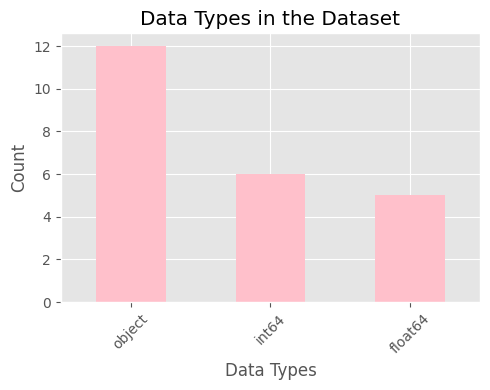

In [19]:
# Get data type counts
data_type_counts = df.dtypes.value_counts()

# Create a bar plot to visualize data types
plt.figure(figsize=(5, 4))
data_type_counts.plot(kind='bar', color='pink')
plt.title('Data Types in the Dataset')
plt.xlabel('Data Types')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
print('Genuine:', round(df['is_fraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds:', round(df['is_fraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Genuine: 99.48 % of the dataset
Frauds: 0.52 % of the dataset


99.48% is the genuine trabsaction and 0.52% is fruad transaction.the transaction accuracy is 99.48%

C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


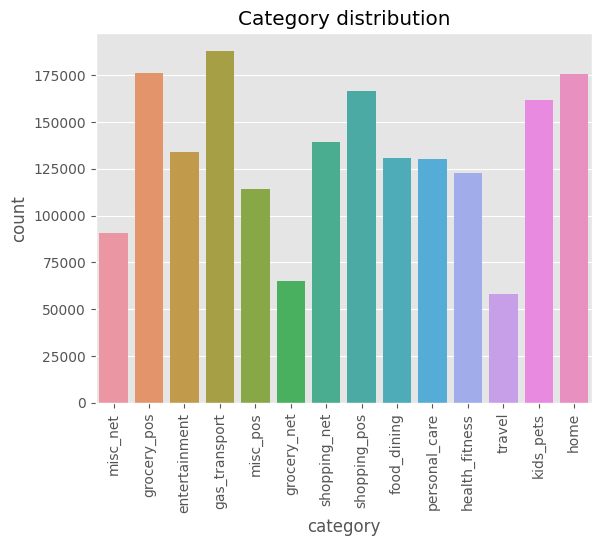

In [21]:
sns.countplot(x='category', data=df)
plt.title('Category distribution')
plt.xticks(rotation=90)
plt.show()

highest transaction giong on in gas_transport above 1,75000

Gender report:

C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


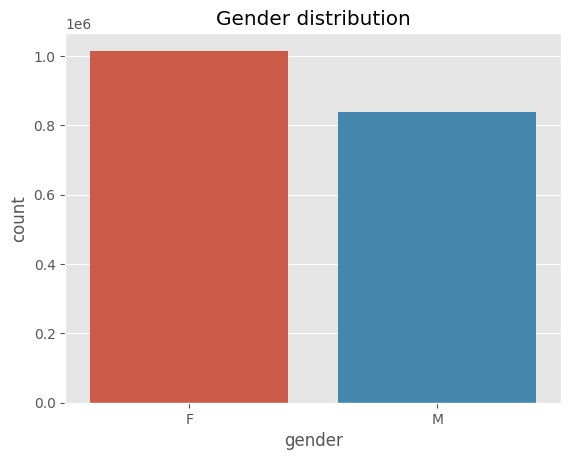

<Figure size 400x400 with 0 Axes>

In [22]:
sns.countplot(x='gender', data=df)
plt.title('Gender distribution')
plt.figure(figsize=(4, 4))
plt.show()


female transaction is more than male transaction.

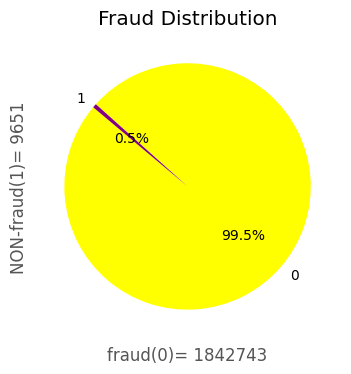

is_fraud
0    1842743
1       9651
Name: count, dtype: int64


In [23]:
import matplotlib.pyplot as plt

# Count occurrences of '0' and '1' in the 'target_column'
counts = df['is_fraud'].value_counts()
plt.figure(figsize=(4, 4))
colors = ['yellow', 'purple']
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Fraud Distribution')
plt.xlabel('fraud(0)= 1842743')
plt.ylabel('NON-fraud(1)= 9651')
plt.show()
print(counts)

In [24]:
#  Converting data type of trans_date_trans_time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df.dtypes['trans_date_trans_time']

# Derive 'Transaction Hour' Feature from 'Transaction Time' Feature
df['time'] = df['trans_date_trans_time'].dt.strftime('%H:%M:%S')
df['time']

0          00:00:18
1          00:00:44
2          00:00:51
3          00:01:16
4          00:03:06
             ...   
1852389    23:59:07
1852390    23:59:09
1852391    23:59:15
1852392    23:59:24
1852393    23:59:34
Name: time, Length: 1852394, dtype: object

In [25]:
# Derive 'Day of Week' Feature from 'Transaction Time' Feature
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()
df['day_of_week']

0           Tuesday
1           Tuesday
2           Tuesday
3           Tuesday
4           Tuesday
             ...   
1852389    Thursday
1852390    Thursday
1852391    Thursday
1852392    Thursday
1852393    Thursday
Name: day_of_week, Length: 1852394, dtype: object

In [26]:
# Derive 'month - year' feature
df['Month']  = pd.DatetimeIndex(df['trans_date_trans_time']).month
df['Year'] = pd.DatetimeIndex(df['trans_date_trans_time']).year

In [27]:
# Convert 'DOB' to datetime if it's not already
df['dob'] = pd.to_datetime(df['dob'])
# Calculate age
current_date = pd.Timestamp('now')
df['age'] = current_date.year - df['dob'].dt.year
# Sort the DataFrame by the "age" column in ascending order
df.sort_values(by='age')
df['age']

0          35
1          45
2          61
3          56
4          37
           ..
1852389    57
1852390    24
1852391    42
1852392    58
1852393    30
Name: age, Length: 1852394, dtype: int32

In [28]:
# Define the age groups
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20','21-40','41-60', '61-80', '81-100']

# Use the cut function to create the age_group feature
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

# Display the DataFrame with the new age_group feature
df['age_group']

0          21-40
1          41-60
2          61-80
3          41-60
4          21-40
           ...  
1852389    41-60
1852390    21-40
1852391    41-60
1852392    41-60
1852393    21-40
Name: age_group, Length: 1852394, dtype: category
Categories (5, object): ['0-20' < '21-40' < '41-60' < '61-80' < '81-100']

In [29]:
#Calculate distance between merchant and home location
df['latitudinal_distance'] = abs(round(df['merch_lat']-df['lat'],3))
df['longitudinal_distance'] = abs(round(df['merch_long']-df['long'],3))
df['longitudinal_distance']

0          0.870
1          0.024
2          0.108
3          0.447
4          0.830
           ...  
1852389    0.558
1852390    0.747
1852391    0.813
1852392    0.632
1852393    0.443
Name: longitudinal_distance, Length: 1852394, dtype: float64

**One-hot encoding:**

In [30]:
df = pd.get_dummies(df, columns=['category'], prefix='category')

df = df.reindex(columns=df.columns, fill_value=0)

In [31]:
# Convert categorical column into numerical 
df['category_entertainment']=df['category_entertainment'].astype(int)
df['category_kids_pets']=df['category_kids_pets'].astype(int)
df['category_shopping_pos']=df['category_shopping_pos'].astype(int)
df['category_travel']=df['category_travel'].astype(int)
df['category_health_fitness']=df['category_health_fitness'].astype(int)
df['category_home']=df['category_home'].astype(int)
df['category_misc_pos']=df['category_misc_pos'].astype(int)
df['category_shopping_net']=df['category_shopping_net'].astype(int)
df['category_gas_transport']=df['category_gas_transport'].astype(int)
df['category_misc_net']=df['category_misc_net'].astype(int)
df['category_grocery_net']=df['category_grocery_net'].astype(int)
df['category_kids_pets']=df['category_kids_pets'].astype(int)
df['category_personal_care'] = df['category_personal_care'].astype(int)
df['category_grocery_pos'] = df['category_grocery_pos'].astype(int)

In [32]:
# Convert gender into numerical 
df.gender=df.gender.apply(lambda x: 1 if x=="M" else 0)

1 for male 0 for female.

**Droping columns:**

In [33]:
columns_drop = ['trans_num','unix_time','first','last','street','zip','age_group','day_of_week', 'state','time','Unnamed: 0','cc_num','merchant','trans_date_trans_time','city','lat','long','job','dob','merch_lat','merch_long']

# Use the drop method to remove the specified columns
df = df.drop(columns=columns_drop)

**spliting test and train data:**

In [34]:
# Split the data into features (X) and target (y)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

features = (X) and target = (y)

In [35]:
# Split into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1481915, 22), (370479, 22), (1481915,), (370479,))

**Modeling non_Oversampling:(Imp)**

**Logical Recursion model**

In [36]:
# Create and train a Logistic Regression model on the non-oversampled data
lr_non_oversampled = LogisticRegression(random_state=42)
lr_non_oversampled.fit(X_train, y_train)

LogisticRegression(random_state=42)


Logistic Regression Classifier :
Accuracy: 0.9942938736068712
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    368526
           1       0.00      0.00      0.00      1953

    accuracy                           0.99    370479
   macro avg       0.50      0.50      0.50    370479
weighted avg       0.99      0.99      0.99    370479



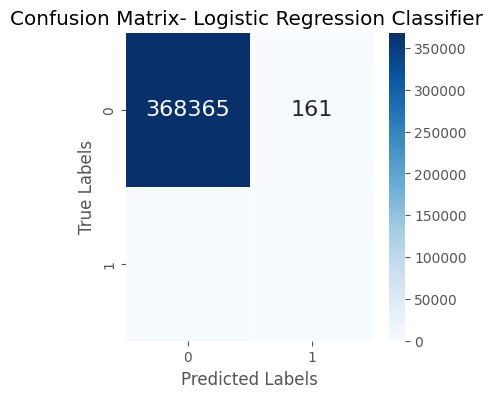

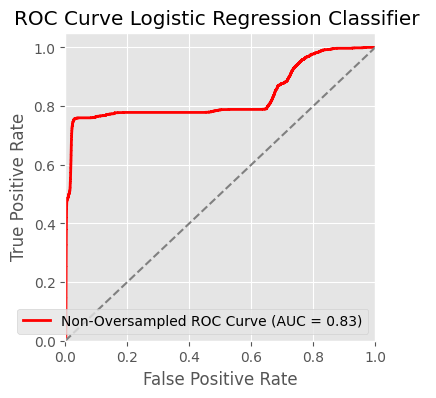

In [37]:
# Predictions
# Make predictions on the non-oversampled test set
y_pred_non_oversampled = lr_non_oversampled.predict(X_test)
y_proba_non_oversampled_lr = lr_non_oversampled.predict_proba(X_test)[:, 1]

# Create confusion matrix for non-oversampled model
accuracy = accuracy_score(y_test, y_pred_non_oversampled)
cm_non_oversampled = confusion_matrix(y_test, y_pred_non_oversampled)
classification_report_result = classification_report(y_test, y_pred_non_oversampled)

# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled, tpr_non_oversampled, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled_lr)
auc_non_oversampled = roc_auc_score(y_test, y_proba_non_oversampled_lr)

# Evaluate the non-oversampled model
print("\nLogistic Regression Classifier :")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred_non_oversampled))

# Create heatmap for non-oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm_non_oversampled, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix- Logistic Regression Classifier ')


# Plot ROC curve for non-oversampled model
plt.figure(figsize=(4, 4))
plt.plot(fpr_non_oversampled, tpr_non_oversampled, color='red', lw=2, label=f'Non-Oversampled ROC Curve (AUC = {auc_non_oversampled:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression Classifier ')
plt.legend(loc='lower right')
plt.show()

accuracy is 99.43%.


**Random Forest classifier**

In [38]:
# Create and train a Random Forest classifier on the non-oversampled data
rf_non_oversampled = RandomForestClassifier(random_state=42)
rf_non_oversampled.fit(X_train, y_train)

RandomForestClassifier(random_state=42)


Random Forest Classifier:
Accuracy: 0.9977542586759304
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.88      0.67      0.76      1953

    accuracy                           1.00    370479
   macro avg       0.94      0.83      0.88    370479
weighted avg       1.00      1.00      1.00    370479



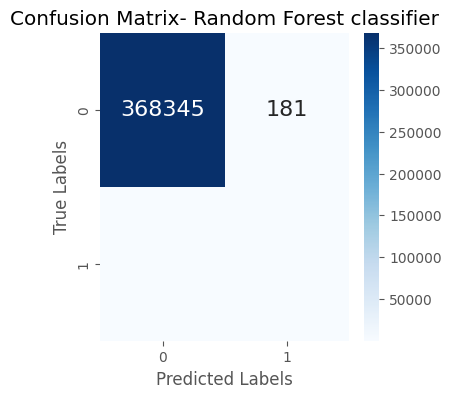

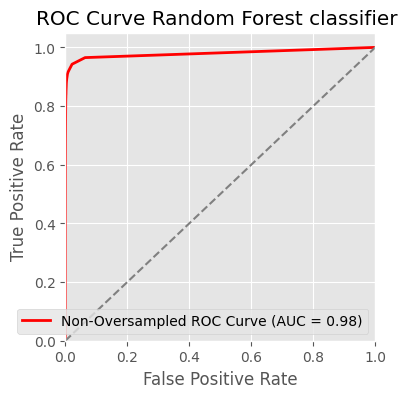

In [39]:
# Predictions
# Make predictions on the non-oversampled test set
y_pred_non_oversampled = rf_non_oversampled.predict(X_test)
y_proba_non_oversampled_rf = rf_non_oversampled.predict_proba(X_test)[:, 1]

# Create confusion matrix for non-oversampled model
accuracy = accuracy_score(y_test, y_pred_non_oversampled)
cm_non_oversampled = confusion_matrix(y_test, y_pred_non_oversampled)
classification_report_result = classification_report(y_test, y_pred_non_oversampled)

# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled, tpr_non_oversampled, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled_rf)
auc_non_oversampled = roc_auc_score(y_test, y_proba_non_oversampled_rf)

# Create heatmap for non-oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm_non_oversampled, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16} )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix- Random Forest classifier')

# Evaluate the non-oversampled model
print("\nRandom Forest Classifier:")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred_non_oversampled))

# Plot ROC curve for non-oversampled Random Forest model
plt.figure(figsize=(4, 4))
plt.plot(fpr_non_oversampled, tpr_non_oversampled, color='red', lw=2, label=f'Non-Oversampled ROC Curve (AUC = {auc_non_oversampled:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest classifier ')
plt.legend(loc='lower right')
plt.show()

accuray 99.77%.

**XG Boost:**

In [44]:
# Create and train an XGBoost classifier on the non-oversampled data
xgb_non_oversampled = XGBClassifier(random_state=42)
xgb_non_oversampled.fit(X_train, y_train)

C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins


XGBoost Classifier:
Accuracy: 0.9977245673843862
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.88      0.66      0.75      1953

    accuracy                           1.00    370479
   macro avg       0.94      0.83      0.88    370479
weighted avg       1.00      1.00      1.00    370479



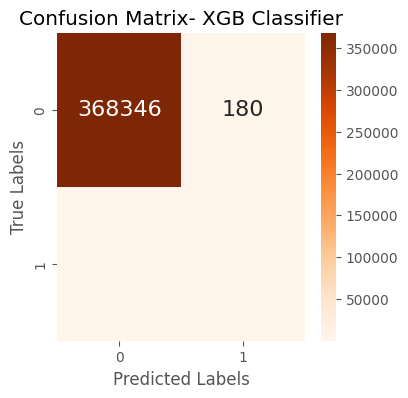

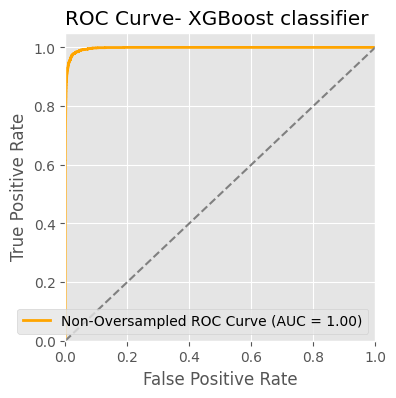

In [54]:
# Predictions
# Make predictions on the non-oversampled test set
y_pred_non_oversampled = xgb_non_oversampled.predict(X_test)
y_proba_non_oversampled_x = xgb_non_oversampled.predict_proba(X_test)[:, 1]

# Create confusion matrix for non-oversampled model
accuracy = accuracy_score(y_test, y_pred_non_oversampled)
cm_non_oversampled = confusion_matrix(y_test, y_pred_non_oversampled)
classification_report_result = classification_report(y_test, y_pred_non_oversampled)

# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled, tpr_non_oversampled, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled_x)
auc_non_oversampled = roc_auc_score(y_test, y_proba_non_oversampled_x)

# Create heatmap for non-oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm_non_oversampled, annot=True, fmt='d', cmap='Oranges', annot_kws={'size': 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix- XGB Classifier')


# Evaluate the non-oversampled model
print("\nXGBoost Classifier:")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred_non_oversampled))

# Plot ROC curve for non-oversampled XGBoost model
plt.figure(figsize=(4, 4))
plt.plot(fpr_non_oversampled, tpr_non_oversampled, color='orange', lw=2, label=f'Non-Oversampled ROC Curve (AUC = {auc_non_oversampled:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- XGBoost classifier ')
plt.legend(loc='lower right')
plt.show()

Accuracy level of XG Boost is 99.77%

**Decision Tree Model:**

In [51]:
# Create and train a Decision Tree classifier on the non-oversampled data
dt_non_oversampled = DecisionTreeClassifier(random_state=42)
dt_non_oversampled.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)


Decision Tree Classifier :
Accuracy: 0.9966151927639624
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.68      0.68      0.68      1953

    accuracy                           1.00    370479
   macro avg       0.84      0.84      0.84    370479
weighted avg       1.00      1.00      1.00    370479



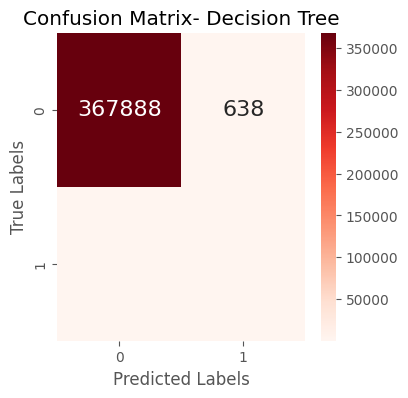

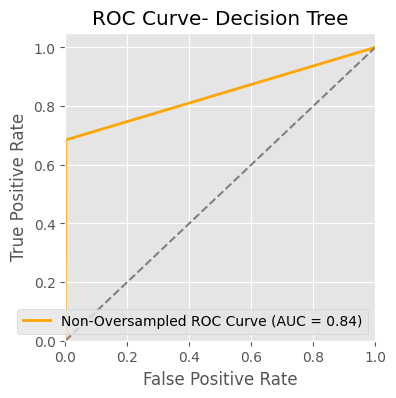

In [55]:
# Predict probabilities on the non-oversampled test set
y_pred_non_oversampled = dt_non_oversampled.predict(X_test)
y_proba_non_oversampled = dt_non_oversampled.predict_proba(X_test)[:, 1]

# Create confusion matrix for non-oversampled model
accuracy = accuracy_score(y_test, y_pred_non_oversampled)
cm_non_oversampled = confusion_matrix(y_test, y_pred_non_oversampled)
classification_report_result = classification_report(y_test, y_pred_non_oversampled)

# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled, tpr_non_oversampled, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled)
auc_non_oversampled = roc_auc_score(y_test, y_proba_non_oversampled)

# Create heatmap for non-oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm_non_oversampled, annot=True, fmt='d', cmap='Reds', annot_kws={'size': 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix- Decision Tree')


# Evaluate the non-oversampled model
print("\nDecision Tree Classifier :")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred_non_oversampled))

# Plot ROC curve for non-oversampled Decision Tree model
plt.figure(figsize=(4, 4))
plt.plot(fpr_non_oversampled, tpr_non_oversampled, color='orange', lw=2, label=f'Non-Oversampled ROC Curve (AUC = {auc_non_oversampled:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Decision Tree')
plt.legend(loc='lower right')
plt.show()


Accuracy rate is 99.6%

**Roc curve of models**

C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

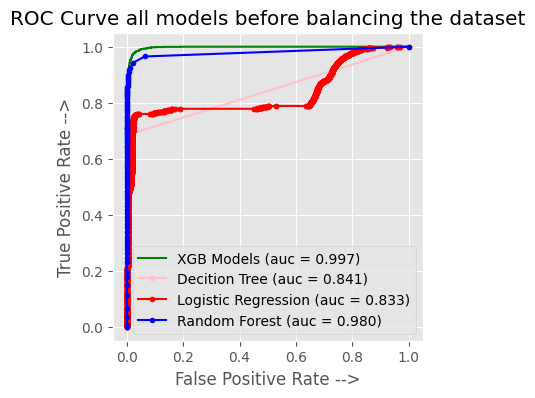

In [56]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities on the non-oversampled test set
y_proba_non_oversampled_x = xgb_non_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled_x, tpr_non_oversampled_x, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled_x)
auc_non_oversampled_x = roc_auc_score(y_test, y_proba_non_oversampled_x)

# Predict probabilities on the non-oversampled test set
y_proba_non_oversampled_lr = lr_non_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled_lr, tpr_non_oversampled_lr, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled_lr)
auc_non_oversampled_lr = roc_auc_score(y_test, y_proba_non_oversampled_lr)

# Predict probabilities on the non-oversampled test set
y_proba_non_oversampled_rf = rf_non_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled_rf, tpr_non_oversampled_rf, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled_rf)
auc_non_oversampled_rf = roc_auc_score(y_test, y_proba_non_oversampled_rf)

# Predict probabilities on the non-oversampled test set
y_proba_non_oversampled = dt_non_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled, tpr_non_oversampled, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled)
auc_non_oversampled = roc_auc_score(y_test, y_proba_non_oversampled)


plt.figure(figsize=(4, 4), dpi=100)
plt.plot(fpr_non_oversampled_x, tpr_non_oversampled_x, linestyle='-',color='green', label='XGB Models (auc = %0.3f)' % auc_non_oversampled_x)
plt.plot(fpr_non_oversampled, tpr_non_oversampled, marker='.',color='pink' ,label='Decition Tree (auc = %0.3f)' % auc_non_oversampled)
plt.plot(fpr_non_oversampled_lr, tpr_non_oversampled_lr, marker='.',color='red' ,label='Logistic Regression (auc = %0.3f)' % auc_non_oversampled_lr)
plt.plot(fpr_non_oversampled_rf, tpr_non_oversampled_rf, marker='.',color='blue' ,label='Random Forest (auc = %0.3f)' % auc_non_oversampled_rf)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.title('ROC Curve all models before balancing the dataset')
plt.legend(loc='lower right')
plt.legend()
plt.show()

**Observation:**
XGboost and Random Forest are the best for the dataset.(Best Fit)

**Modeling by oversamplying**

In [57]:
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [58]:
X_train_resampled.shape

(2948434, 22)

In [59]:
y_train_resampled.shape

(2948434,)

**Logical Regression**

In [61]:
lr_oversampled = LogisticRegression(random_state=42)
lr_oversampled.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=42)

Logistic Regression Classifier with Oversampling:
Accuracy: 0.9522483055719757
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98    368526
           1       0.08      0.76      0.14      1953

    accuracy                           0.95    370479
   macro avg       0.54      0.86      0.56    370479
weighted avg       0.99      0.95      0.97    370479



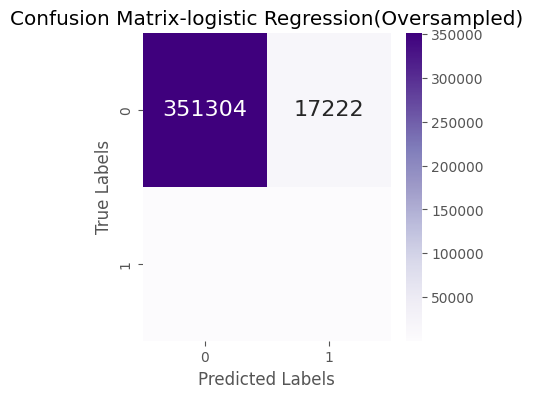

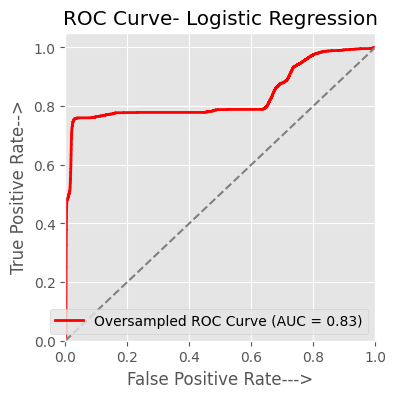

In [65]:
# Predict probabilities on the oversampled test set
y_pred = lr_oversampled.predict(X_test)
y_proba = lr_oversampled.predict_proba(X_test)[:, 1]

# Create confusion matrix for oversampled model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Create heatmap for oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', annot_kws={'size': 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-logistic Regression(Oversampled)')

# Evaluate the oversampled model
print("Logistic Regression Classifier with Oversampling:")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve for oversampled Decision Tree model
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='red', lw=2, label=f'Oversampled ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate--->')
plt.ylabel('True Positive Rate-->')
plt.title('ROC Curve- Logistic Regression')
plt.legend(loc='lower right')
plt.show()

Accuracy : 95.2%

**Random Forest Classifier(Oversample data):**

In [66]:
# Create and train a Random Forest classifier on the oversampled data
rf_oversampled = RandomForestClassifier(random_state=42)
rf_oversampled.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

Random Forest Classifier with Oversampling:
Accuracy: 0.9978271373006298
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.84      0.73      0.78      1953

    accuracy                           1.00    370479
   macro avg       0.92      0.86      0.89    370479
weighted avg       1.00      1.00      1.00    370479



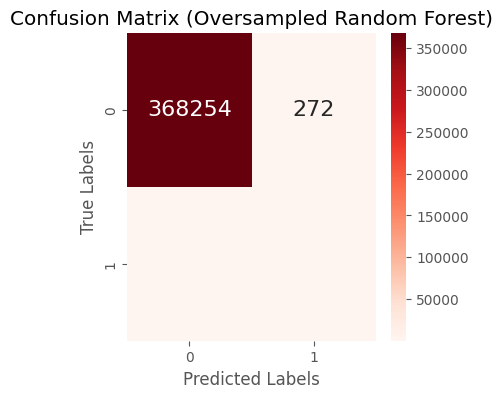

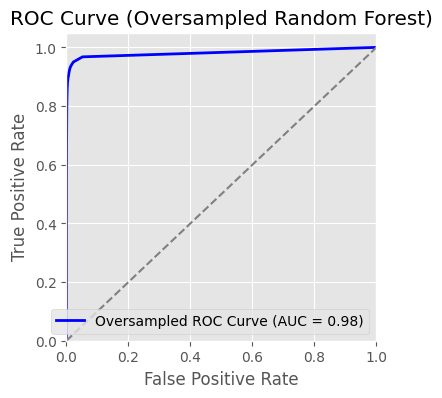

In [68]:
# Predict probabilities on the non-oversampled test set
y_pred = rf_oversampled.predict(X_test)
y_proba = rf_oversampled.predict_proba(X_test)[:, 1]

# Create confusion matrix for oversampled model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Create heatmap for oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', annot_kws={'size': 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Oversampled Random Forest)')

# Evaluate the oversampled model
print("Random Forest Classifier with Oversampling:")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve for oversampled Random Forest model
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Oversampled ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Oversampled Random Forest)')
plt.legend(loc='lower right')
plt.show()

Accuracy : 99.8%

**Decision Tree Classifier :(Oversampled data)**

In [69]:
# Create and train a Decision Tree classifier on the oversampled data
dt_oversampled = DecisionTreeClassifier(random_state=42)
dt_oversampled.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

Decision Tree Classifier with Oversampling:
Accuracy: 0.9967366571384613
Classification Report:
accuracy Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.71      0.65      0.68      1953

    accuracy                           1.00    370479
   macro avg       0.85      0.83      0.84    370479
weighted avg       1.00      1.00      1.00    370479



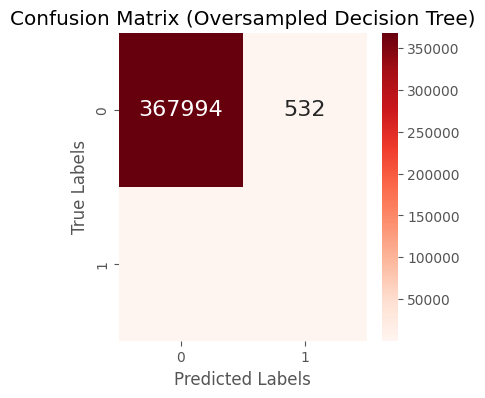

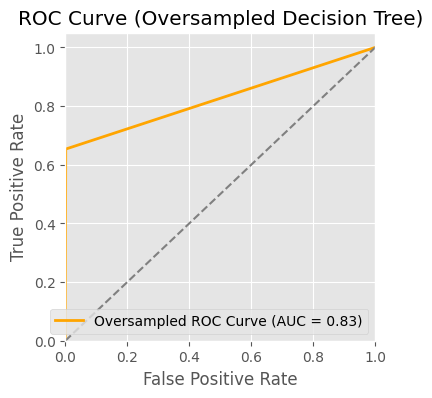

In [74]:
# Predict probabilities on the non-oversampled test set
y_pred = dt_oversampled.predict(X_test)
y_proba = dt_oversampled.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Create confusion matrix for oversampled model
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Create heatmap for oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', annot_kws={'size': 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Oversampled Decision Tree)')

# Evaluate the oversampled model
print("Decision Tree Classifier with Oversampling:")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print("accuracy Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve for oversampled Decision Tree model
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='Orange', lw=2, label=f'Oversampled ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Oversampled Decision Tree)')
plt.legend(loc='lower right')
plt.show()

**XGBoost:**

In [75]:
# Create and train an XGBoost classifier on the oversampled data
xgb_oversampled = XGBClassifier(random_state=42)
xgb_oversampled.fit(X_train_resampled, y_train_resampled)

C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

XGBoost Classifier with Oversampling:
Accuracy: 0.9842636154815793
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    368526
           1       0.24      0.95      0.39      1953

    accuracy                           0.98    370479
   macro avg       0.62      0.97      0.69    370479
weighted avg       1.00      0.98      0.99    370479



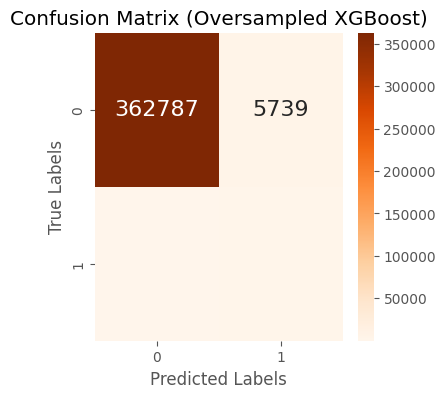

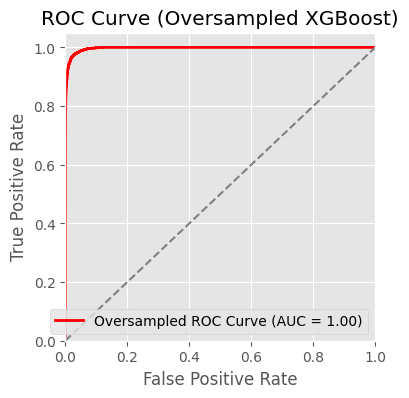

In [76]:
# Predict probabilities on the non-oversampled test set
y_pred = xgb_oversampled.predict(X_test)
y_proba = xgb_oversampled.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Create confusion matrix for oversampled model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Create heatmap for oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', annot_kws={'size': 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Oversampled XGBoost)')

# Evaluate the oversampled model
print("XGBoost Classifier with Oversampling:")
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve for oversampled XGBoost model
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='red', lw=2, label=f'Oversampled ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Oversampled XGBoost)')
plt.legend(loc='lower right')
plt.show()

Accuracy : 98.4%

**Roc Curve**

C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\dipma\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

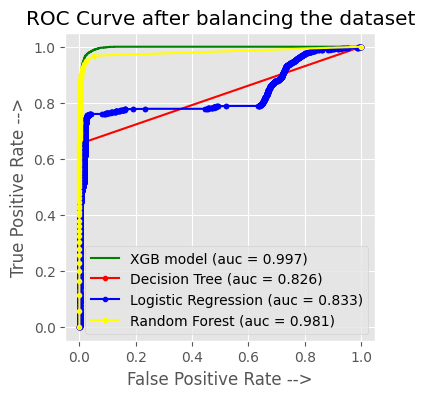

In [78]:
# Predict probabilities on the non-oversampled test set
y_proba = xgb_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_proba)
auc_xgb = roc_auc_score(y_test, y_proba)

# Predict probabilities on the non-oversampled test set
y_proba_dt = dt_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score
fpr_dt, tpr_dt, thresholds = roc_curve(y_test, y_proba_dt)
auc_dt = roc_auc_score(y_test, y_proba_dt)

# Predict probabilities on the non-oversampled test set
y_proba_rf = rf_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

# Predict probabilities on the non-oversampled test set
y_proba_lr = lr_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

plt.figure(figsize=(4, 4), dpi=100)
plt.plot(fpr_xgb, tpr_xgb, linestyle='-',color='green', label='XGB model (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_dt, tpr_dt, marker='.',color='red' ,label='Decision Tree (auc = %0.3f)' % auc_dt)
plt.plot(fpr_lr, tpr_lr, marker='.',color='blue' ,label='Logistic Regression (auc = %0.3f)' % auc_lr)
plt.plot(fpr_rf, tpr_rf, marker='.',color='yellow' ,label='Random Forest (auc = %0.3f)' % auc_rf)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.title('ROC Curve after balancing the dataset')
plt.legend(loc='lower right')
plt.legend()
plt.show()

**Observation For the project:**


* XGBoost model have highest AUC in the non_over sample and Oversample case.
* Random forest model also a relatively good model. Because It also have a high AUC. 

**Decision Of the report:**

We will use XGBoost Algorithm.